# Importing Libraries

In [51]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
%matplotlib inline

# Loading Data

In [52]:
dataset_path = os.listdir("Datasets/Data")
pest_types = os.listdir("Datasets/Data")
print(pest_types)
print("dataset folders found are: " + str(len(dataset_path)))

['Others', 'Locust']
dataset folders found are: 2


In [53]:
pests = []
for item in dataset_path:
    # Get all file names
    all_pests = os.listdir("Datasets/Data" + "/" + item)
    # print(all_signatures)
    
    # Add them to the list
    for pest in all_pests:
        pests.append((item, str("Datasets/Data" + "/" + item) + "/" + pest))
        
print(pests)

[('Others', 'Datasets/Data/Others/FruitMothImage91 copy 4.jpeg'), ('Others', 'Datasets/Data/Others/GallFlyImage433.jpeg'), ('Others', 'Datasets/Data/Others/StemBorerImage7.jpeg'), ('Others', 'Datasets/Data/Others/FruitMothImage100 copy 9.jpeg'), ('Others', 'Datasets/Data/Others/FruitMothImage96 copy 7.jpeg'), ('Others', 'Datasets/Data/Others/FruitMothImage132.jpeg'), ('Others', 'Datasets/Data/Others/StemBorerImage169.jpeg'), ('Others', 'Datasets/Data/Others/GallFlyImage126.jpeg'), ('Others', 'Datasets/Data/Others/GallFlyImage258.jpeg'), ('Others', 'Datasets/Data/Others/FruitMothImage98 copy 8.jpeg'), ('Others', 'Datasets/Data/Others/FruitMothImage309.jpeg'), ('Others', 'Datasets/Data/Others/FruitMothImage103 copy 2.jpeg'), ('Others', 'Datasets/Data/Others/GallFlyImage464.jpeg'), ('Others', 'Datasets/Data/Others/GallFlyImage171.jpeg'), ('Others', 'Datasets/Data/Others/FruitMothImage165.jpeg'), ('Others', 'Datasets/Data/Others/FruitMothImage109 copy 5.jpeg'), ('Others', 'Datasets/Data/Ot

# Exploring The Dataset

In [54]:
# Building a dataframe

pests_df = pd.DataFrame(data=pests, columns=["Label", "Pest_Image"])
pests_df.head()

,Label,Pest_Image
0,Others,Datasets/Data/Others/FruitMothImage91 copy 4.jpeg
1,Others,Datasets/Data/Others/GallFlyImage433.jpeg
2,Others,Datasets/Data/Others/StemBorerImage7.jpeg
3,Others,Datasets/Data/Others/FruitMothImage100 copy 9....
4,Others,Datasets/Data/Others/FruitMothImage96 copy 7.jpeg


In [55]:
print("Total number of pests in the dataset: " + str(len(pests_df)))
print("Shape of the dataset: " + str((pests_df.shape)))
print("Null Values Exist: " + str(pests_df.isnull().any()))

Total number of pests in the dataset: 2148
Shape of the dataset: (2148, 2)
Null Values Exist: Label         False
Pest_Image    False
dtype: bool


In [56]:
pests_df.groupby("Label").count().transpose()

Label,Locust,Others
Pest_Image,752,1396


<AxesSubplot:xlabel='Label', ylabel='count'>

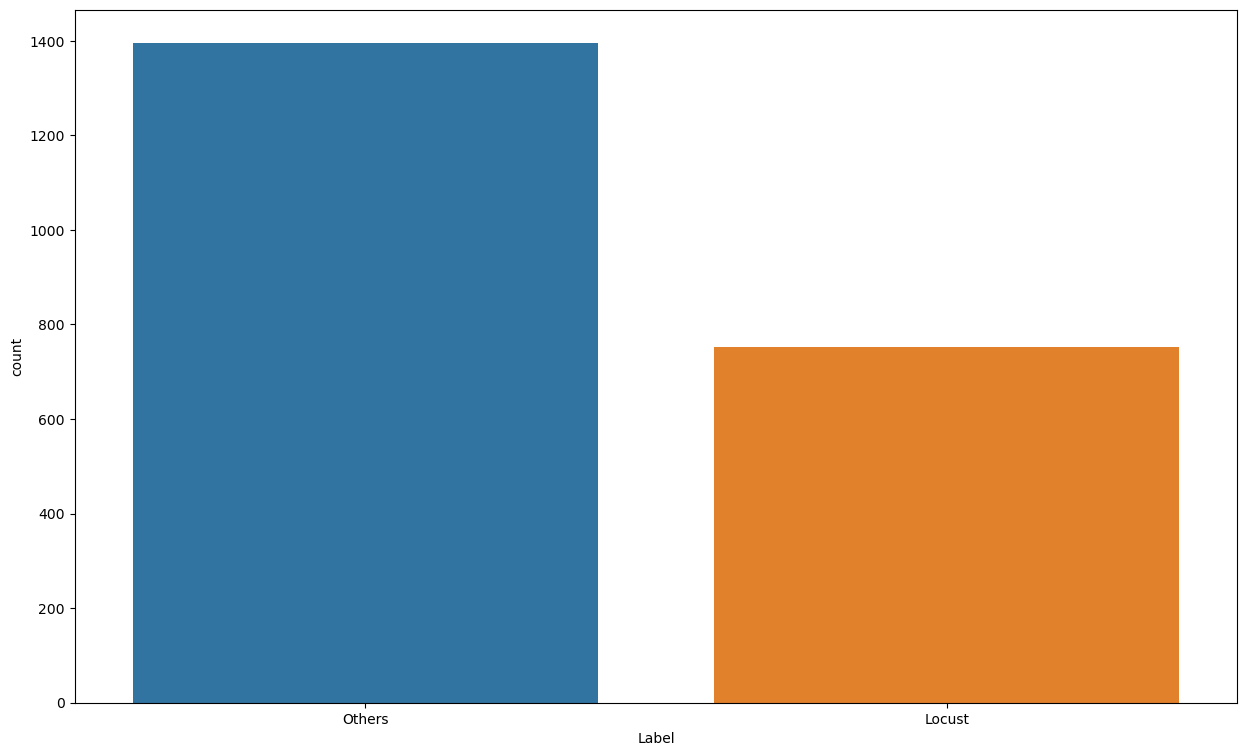

In [57]:
plt.figure(figsize=(15,9))
sns.countplot(x=pests_df["Label"])

In [58]:
path = "Datasets/Data/"

im_size = 150

images = []
labels = []

for i in pest_types:
    data_path = path + str(i)
    filenames = [i for i in os.listdir(data_path)]
    
    for f in filenames:
        img = cv2.imread(data_path + "/" + f)
        if img is None:
            print('Wrong path:', data_path)
        else:
            img = cv2.resize(img, (im_size, im_size))
            images.append(img)
            labels.append(i)

Wrong path: Datasets/Data/Others
Wrong path: Datasets/Data/Locust


In [59]:
images = np.array(images, dtype="float32")
images.shape

(2146, 150, 150, 3)

In [60]:
label = pd.DataFrame(labels, columns=["labels"])
label.head()

,labels
0,Others
1,Others
2,Others
3,Others
4,Others


In [61]:
y_labelencoder = LabelEncoder()
Y = label["labels"].values
Y = y_labelencoder.fit_transform(Y)
Y = np.array(Y, dtype="int32")
Y

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [62]:
images, Y = shuffle(images, Y, random_state = 1)
x_train, x_test, y_train, y_test = train_test_split(images, Y, test_size=0.2, random_state = 5)
print("Training Set Features: ", x_train.shape)
print("Training Set Lables: ", y_train.shape)
print("Test Set Features: ", x_test.shape)
print("Test Set Labels: ", y_test.shape)

Training Set Features:  (1716, 150, 150, 3)
Training Set Lables:  (1716,)
Test Set Features:  (430, 150, 150, 3)
Test Set Labels:  (430,)


In [63]:
def process(image):
    tf.cast(image/255., tf.float32)
    return image

x_train = process(x_train)
x_test = process(x_test)

# Building Custom CNN Model

In [64]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)
cnn_model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation = "relu", input_shape = (150, 150, 3)), layers.MaxPooling2D(),
    layers.Conv2D(32, (3,3), activation = "relu", input_shape = (150, 150, 3)), layers.MaxPooling2D(),
    layers.Conv2D(32, (3,3), activation = "relu"), layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(6, activation=tf.nn.softmax)
    
])

cnn_model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

history = cnn_model.fit(x_train, y_train, epochs=10, validation_data = (x_test, y_test), callbacks = [early_stop])
history

Epoch 1/10
54/54 [==============================] - 20s 356ms/step - loss: 10.7202 - accuracy: 0.7145 - val_loss: 0.3935 - val_accuracy: 0.8442
Epoch 2/10
54/54 [==============================] - 19s 357ms/step - loss: 0.2563 - accuracy: 0.8969 - val_loss: 0.3326 - val_accuracy: 0.8581
Epoch 3/10
54/54 [==============================] - 19s 354ms/step - loss: 0.1501 - accuracy: 0.9458 - val_loss: 0.4833 - val_accuracy: 0.8721
Epoch 4/10
54/54 [==============================] - 19s 351ms/step - loss: 0.0902 - accuracy: 0.9720 - val_loss: 0.4098 - val_accuracy: 0.9000
Epoch 5/10
54/54 [==============================] - 19s 349ms/step - loss: 0.0526 - accuracy: 0.9814 - val_loss: 0.4727 - val_accuracy: 0.8581
Epoch 6/10
54/54 [==============================] - 19s 360ms/step - loss: 0.0318 - accuracy: 0.9924 - val_loss: 0.4243 - val_accuracy: 0.8977
Epoch 7/10
54/54 [==============================] - 19s 355ms/step - loss: 0.0364 - accuracy: 0.9918 - val_loss: 0.5272 - val_accuracy: 0.865

In [65]:
cnn_output_df = pd.DataFrame(cnn_model.history.history)
cnn_output_df.head(10)

,loss,accuracy,val_loss,val_accuracy
0,10.720160,0.714452,0.393498,0.844186
1,0.256309,0.896853,0.332569,0.858140
2,0.150138,0.945804,0.483306,0.872093
3,0.090160,0.972028,0.409849,0.900000
4,0.052634,0.981352,0.472712,0.858140
5,0.031841,0.992424,0.424255,0.897674
6,0.036369,0.991841,0.527208,0.865116
7,0.036842,0.993590,0.468057,0.881395
8,0.057790,0.981352,0.541357,0.897674
9,0.032495,0.994755,0.536222,0.909302


In [66]:
def plot_accuracy_loss(history):
    
#   plot accuracy
    plt.figure(figsize= (15,10))
    plt.subplot(221)
    plt.plot(history.history["accuracy"], "bo--", label = "Training Accuracy")
    plt.plot(history.history["val_accuracy"], "ro--", label = "Validation Accuracy")
    plt.title("Train Accuracy vs Test Accuracy", fontsize=20)
    plt.ylabel("Accuracy", fontsize=18)
    plt.xlabel("Epochs", fontsize=19)
    plt.legend()
    plt.show()
    
#   plot loss function
    plt.figure(figsize= (15,10))
    plt.subplot(221)
    plt.plot(history.history["loss"], "bo--", label = "Training Loss")
    plt.plot(history.history["val_loss"], "ro--", label = "Validation Loss")
    plt.title("Train Loss vs Test Loss", fontsize=20)
    plt.ylabel("Loss", fontsize=18)
    plt.xlabel("Epochs", fontsize=18)
    plt.legend()
    plt.show()

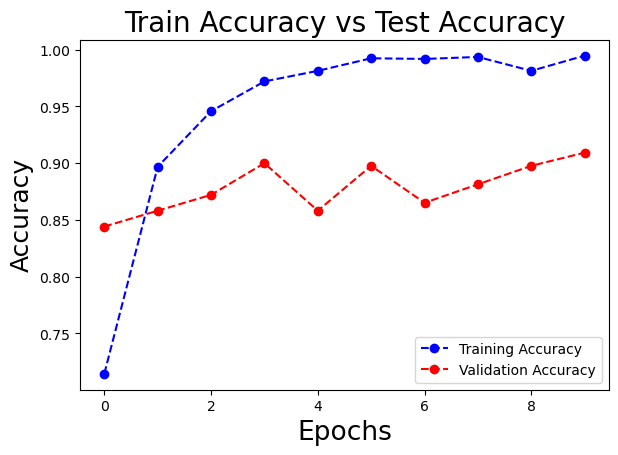

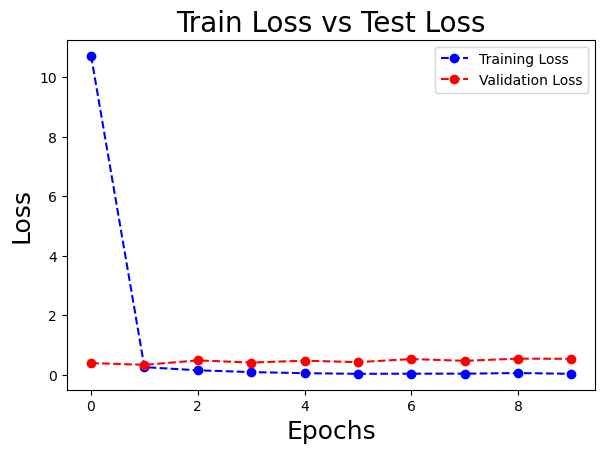

In [67]:
plot_accuracy_loss(history)

In [68]:
cnn_model.evaluate(x_test, y_test)
print(" ")
print(" ")
y_pred = cnn_model.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print(" ")
print(" ")
print("classification_report: \n", classification_report(y_test, y_pred_classes))
print(" ")
print(" ")
print("Confussion Matrix: \n", confusion_matrix(y_test, y_pred_classes))

14/14 [==============================] - 1s 72ms/step - loss: 0.5362 - accuracy: 0.9093
 
 
14/14 [==============================] - 1s 76ms/step
 
 
classification_report: 
               precision    recall  f1-score   support

           0       0.89      0.81      0.85       134
           1       0.92      0.96      0.94       296

    accuracy                           0.91       430
   macro avg       0.90      0.88      0.89       430
weighted avg       0.91      0.91      0.91       430

 
 
Confussion Matrix: 
 [[108  26]
 [ 13 283]]
